In [111]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import f1_score
from feature_engine.imputation import MeanMedianImputer
from featuretools.selection import remove_single_value_features, remove_highly_correlated_features
from tqdm import tqdm
import warnings
from catboost import CatBoostClassifier

warnings.simplefilter('ignore')

In [112]:
seed = 22

In [157]:
df = pd.read_csv('train.csv')

In [158]:
df

,application_1,cc_1,cc_2,cc_3,cc_4,feature_1,mb_1,cc_5,cc_6,feature_2,...,cc_21,application_15,feature_25,feature_26,cc_22,partner_24,application_16,retro_date,successful_utilization,treatment
0,NaN,1.0,Representatives,123.0,Первичная ДК,1,14.0,147000.0,PLT,0.0,...,NaN,0,1.0,0.0,-1.2,1.0,0,2024-07-04,0,1
1,NaN,1.0,Offline,43.0,Airports,0,1.0,120000.0,PLT,0.0,...,1.0,0,1.0,0.0,-1.2,1.0,0,2024-06-06,0,1
2,0.0,1.0,Web,2.0,seo,0,NaN,15000.0,PLT,0.0,...,NaN,0,NaN,0.0,-1.2,1.0,0,2024-07-21,1,1
3,0.0,1.0,MB,2.0,One Click Offer,0,91.0,260000.0,PLT,0.0,...,1.0,0,NaN,1.0,-1.2,1.0,0,2024-05-23,0,1
4,0.0,1.0,Representatives,123.0,Первичная ДК,1,1.0,130000.0,PLT,0.0,...,NaN,0,1.0,0.0,-1.2,1.0,0,2024-06-28,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
297245,NaN,1.0,Representatives,123.0,Первичная ДК,1,34.0,95000.0,PLT,0.0,...,NaN,0,1.0,0.0,-1.2,1.0,0,2024-05-13,1,1
297246,NaN,1.0,Representatives,123.0,Первичная ДК,1,1.0,83000.0,PLT,0.0,...,NaN,0,1.0,0.0,-1.2,NaN,0,2024-07-08,0,1
297247,0.0,1.0,Mobile Warm,2.0,TOOS cor clients,0,2.0,170000.0,PLT,0.0,...,1.0,0,NaN,0.0,1.0,1.0,0,2024-06-12,0,1
297248,0.0,1.0,Representatives,123.0,Первичная ДК,1,5.0,15000.0,PLT,0.0,...,0.0,0,1.0,0.0,-1.2,1.0,0,2024-06-02,1,1


In [159]:
target_col = 'successful_utilization'

In [160]:
X = df.drop(columns=[target_col])
y = df[target_col]

In [161]:
def deliting_nans(df):
    ns = df.isnull().sum()
    df.drop(columns=ns[ns > len(df) * 0.7].index.tolist(), inplace=True)

In [ ]:
def filling_nans(df, imp=None):
    for x in tqdm(df.columns):
        if df[x].dtype == object:
            df[x] = df[x].fillna(df[x].mode().tolist()[0])
    if not imp:
        imp = MeanMedianImputer('mean')
        imp.fit(df)
    df = imp.transform(df)
    print(df.isnull().sum().sum())
    return df, imp 

In [163]:
deliting_nans(X)

In [165]:
X, imp = filling_nans(X)

100%|██████████| 146/146 [00:00<00:00, 1368.03it/s]


(297250, 146)
0


In [166]:
def parse_retro_date(df):
    # Убедимся, что колонка retro_date в формате datetime
    df['retro_date'] = pd.to_datetime(df['retro_date'])
    
    # Создаем новые колонки
    df['year'] = df['retro_date'].dt.year            # Год
    df['month'] = df['retro_date'].dt.month          # Месяц (число)
    df['day'] = df['retro_date'].dt.day              # День месяца
    df['day_of_week'] = df['retro_date'].dt.dayofweek # День недели (0 = Понедельник, 6 = Воскресенье)
    df['week_of_year'] = df['retro_date'].dt.isocalendar().week # Номер недели
    df['quarter'] = df['retro_date'].dt.quarter      # Квартал
    df['is_month_start'] = df['retro_date'].dt.is_month_start.astype(int)  # Является ли началом месяца
    df['is_month_end'] = df['retro_date'].dt.is_month_end.astype(int)      # Является ли концом месяца
    df['day_name'] = df['retro_date'].dt.day_name()  # Название дня недели
    df['month_name'] = df['retro_date'].dt.month_name() # Название месяца
    
    return df

In [167]:
X = parse_retro_date(X)
X = remove_single_value_features(X)

In [168]:
def get_cat_features(df):
    lst = []
    for x in df.columns:
        if (1 < len(df[x].value_counts()) < 20 or df[x].dtype == object) and df[x].dtype in [object, int]:
            lst.append(x)
    return lst

In [169]:
cat_feat = get_cat_features(X)

In [170]:
len(cat_feat)

10

In [171]:
cat_feat

['cc_2',
 'cc_4',
 'cc_6',
 'month',
 'day_of_week',
 'quarter',
 'is_month_start',
 'is_month_end',
 'day_name',
 'month_name']

In [172]:
X

,application_1,cc_2,cc_3,cc_4,feature_1,mb_1,cc_5,cc_6,feature_2,cc_7,...,treatment,month,day,day_of_week,week_of_year,quarter,is_month_start,is_month_end,day_name,month_name
0,226.487834,Representatives,123.0,Первичная ДК,1,14.000000,147000.0,PLT,0.0,0.008663,...,1,7,4,3,27,3,0,0,Thursday,July
1,226.487834,Offline,43.0,Airports,0,1.000000,120000.0,PLT,0.0,0.022936,...,1,6,6,3,23,2,0,0,Thursday,June
2,0.000000,Web,2.0,seo,0,21.836155,15000.0,PLT,0.0,0.036080,...,1,7,21,6,29,3,0,0,Sunday,July
3,0.000000,MB,2.0,One Click Offer,0,91.000000,260000.0,PLT,0.0,0.036080,...,1,5,23,3,21,2,0,0,Thursday,May
4,0.000000,Representatives,123.0,Первичная ДК,1,1.000000,130000.0,PLT,0.0,0.029764,...,1,6,28,4,26,2,0,0,Friday,June
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
297245,226.487834,Representatives,123.0,Первичная ДК,1,34.000000,95000.0,PLT,0.0,0.086722,...,1,5,13,0,20,2,0,0,Monday,May
297246,226.487834,Representatives,123.0,Первичная ДК,1,1.000000,83000.0,PLT,0.0,0.025878,...,1,7,8,0,28,3,0,0,Monday,July
297247,0.000000,Mobile Warm,2.0,TOOS cor clients,0,2.000000,170000.0,PLT,0.0,0.036080,...,1,6,12,2,24,2,0,0,Wednesday,June
297248,0.000000,Representatives,123.0,Первичная ДК,1,5.000000,15000.0,PLT,0.0,0.034553,...,1,6,2,6,22,2,0,0,Sunday,June


In [204]:
def all_preprocessing(df, target_col=None, imp=None):
    deliting_nans(df)
    df_new, imp = filling_nans(df, imp)
    if target_col:
        X = df_new.drop(columns=[target_col])
    else:
        X = df_new
    X = parse_retro_date(X)
    X = remove_single_value_features(X)
    cat_feat = get_cat_features(X)
    return X, cat_feat

In [ ]:
clfs = []
scores = []
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
for i, (train_ind, test_ind) in enumerate(kf.split(X, y)):
    X_train, X_test = X.iloc[train_ind], X.iloc[test_ind]
    y_train, y_test = y.iloc[train_ind], y.iloc[test_ind]
    clf = CatBoostClassifier(iterations=200, learning_rate=0.03, verbose=100, cat_features=cat_feat)
    clf.fit(X_train, y_train)
    clfs.append(clf)
    score = f1_score(y_test, clf.predict(X_test))
    scores.append(score)
    print(f'{i}: {score}')
print(
    "Средняя метрика --", np.mean(scores, dtype="float16"), "Отклонение метрик --", np.std(scores).round(4)
)

In [ ]:
best_model = clfs[np.argmax(scores)]

In [174]:
best_model

In [ ]:
clf = CatBoostClassifier(iterations=1000, learning_rate=0.03, verbose=100, cat_features=cat_feat)
clf.fit(X, y)

0:	learn: 0.6824580	total: 305ms	remaining: 5m 4s
100:	learn: 0.5017446	total: 33.3s	remaining: 4m 56s
200:	learn: 0.4917904	total: 1m 4s	remaining: 4m 17s
300:	learn: 0.4865039	total: 1m 36s	remaining: 3m 43s
400:	learn: 0.4828651	total: 2m 8s	remaining: 3m 12s


In [223]:
test = pd.read_csv('test.csv')
test1 = test.copy()
test2 = test.copy()

test1['treatment'] = 1
test2['treatment'] = 0

In [224]:
test1

,application_1,cc_1,cc_2,cc_3,cc_4,feature_1,mb_1,cc_5,cc_6,feature_2,...,feature_24,cc_21,application_15,feature_25,feature_26,cc_22,partner_24,application_16,retro_date,treatment
0,0.0,1.0,NaN,NaN,NaN,0,6.0,NaN,NaN,0.0,...,0.0,1.0,0,0.0,0.0,-1.2,1.0,0,2024-06-18,1
1,0.0,1.0,NaN,NaN,NaN,0,45.0,NaN,NaN,0.0,...,0.0,0.0,0,0.0,1.0,-1.2,1.0,0,2024-05-09,1
2,0.0,1.0,MB,2.0,Heavy xsell,0,13.0,299000.0,PLT,0.0,...,NaN,NaN,0,NaN,0.0,-1.2,1.0,0,2024-05-30,1
3,0.0,1.0,Representatives,123.0,SIM,1,158.0,140000.0,PLT,0.0,...,0.0,NaN,0,1.0,0.0,-1.2,1.0,0,2024-05-27,1
4,0.0,1.0,Representatives,123.0,Первичная ДК,0,36.0,170000.0,PLT,0.0,...,0.0,0.0,0,1.0,0.0,-1.2,1.0,0,2024-06-08,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74308,NaN,1.0,Representatives,123.0,Multitask,1,NaN,15000.0,PLT,0.0,...,0.0,NaN,0,1.0,0.0,-1.2,1.0,0,2024-05-15,1
74309,0.0,1.0,Representatives,123.0,Первичная ДК,1,12.0,95000.0,PLT,0.0,...,NaN,NaN,0,NaN,0.0,-1.2,1.0,0,2024-07-10,1
74310,0.0,NaN,PreApprove (Mobile Applicants),2.0,Other,0,5.0,15000.0,PLT,0.0,...,0.0,0.0,1,0.0,1.0,-1.2,1.0,1,2024-06-27,1
74311,0.0,1.0,Representatives,123.0,Перевыпуск ДК,1,52.0,70000.0,PLT,0.0,...,0.0,NaN,0,1.0,0.0,-1.2,1.0,0,2024-06-10,1


In [225]:
test1, _ = all_preprocessing(test1, imp=imp)
test2, _ = all_preprocessing(test2, imp=imp)

100%|██████████| 146/146 [00:00<00:00, 2614.11it/s]


0


100%|██████████| 146/146 [00:00<00:00, 4874.57it/s]


0


In [226]:
test1['treatment'] = 1
test2['treatment'] = 0

In [227]:
test1 = test1.reindex(columns=X.columns)
test2 = test2.reindex(columns=X.columns)

In [228]:
test1

,application_1,cc_2,cc_3,cc_4,feature_1,mb_1,cc_5,cc_6,feature_2,cc_7,...,treatment,month,day,day_of_week,week_of_year,quarter,is_month_start,is_month_end,day_name,month_name
0,0.000000,Representatives,80.713643,Первичная ДК,0,6.000000,114473.119667,PLT,0.0,0.293391,...,1,6,18,1,25,2,0,0,Tuesday,June
1,0.000000,Representatives,80.713643,Первичная ДК,0,45.000000,114473.119667,PLT,0.0,0.001504,...,1,5,9,3,19,2,0,0,Thursday,May
2,0.000000,MB,2.000000,Heavy xsell,0,13.000000,299000.000000,PLT,0.0,0.025830,...,1,5,30,3,22,2,0,0,Thursday,May
3,0.000000,Representatives,123.000000,SIM,1,158.000000,140000.000000,PLT,0.0,0.004579,...,1,5,27,0,22,2,0,0,Monday,May
4,0.000000,Representatives,123.000000,Первичная ДК,0,36.000000,170000.000000,PLT,0.0,0.034488,...,1,6,8,5,23,2,0,0,Saturday,June
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74308,226.487834,Representatives,123.000000,Multitask,1,21.836155,15000.000000,PLT,0.0,0.007608,...,1,5,15,2,20,2,0,0,Wednesday,May
74309,0.000000,Representatives,123.000000,Первичная ДК,1,12.000000,95000.000000,PLT,0.0,0.019465,...,1,7,10,2,28,3,0,0,Wednesday,July
74310,0.000000,PreApprove (Mobile Applicants),2.000000,Other,0,5.000000,15000.000000,PLT,0.0,0.036080,...,1,6,27,3,26,2,0,0,Thursday,June
74311,0.000000,Representatives,123.000000,Перевыпуск ДК,1,52.000000,70000.000000,PLT,0.0,0.001493,...,1,6,10,0,24,2,0,0,Monday,June


In [240]:
t1 = best_model.predict_proba(test1)[:, 1]
t2 = best_model.predict_proba(test2)[:, 1]

In [241]:
ans = t1 - t2

In [248]:
pred = pd.read_csv('sample_submission.csv').drop(columns=['Unnamed: 0'])

In [249]:
pred['successful_utilization'] = ans

array([[<Axes: title={'center': 'successful_utilization'}>]], dtype=object)

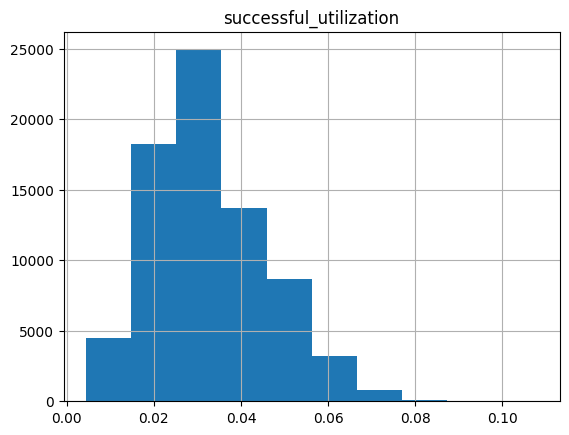

In [251]:
pred.hist()

In [252]:
pred.to_csv('final.csv')